### Duopoly

In [34]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta, self.mean, self.std_dev = theta, mean, std_deviation
        self.dt, self.x_initial = dt, x_initial
        self.reset()
    def __call__(self):
        x = (self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt +
             self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        self.x_prev = x
        return x
    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mean)

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity, self.batch_size = buffer_capacity, batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((buffer_capacity, num_states))
        self.action_buffer = np.zeros((buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((buffer_capacity, 1))
        self.next_state_buffer = np.zeros((buffer_capacity, num_states))
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        (self.state_buffer[index], self.action_buffer[index],
         self.reward_buffer[index], self.next_state_buffer[index]) = obs_tuple
        self.buffer_counter += 1
    @tf.function
    def update(self, actor_model, critic_model, target_actor, target_critic, actor_optimizer, critic_optimizer,state_batch, action_batch, reward_batch, next_state_batch):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
    def learn(self, actor_model, critic_model, target_actor, target_critic,actor_optimizer,critic_optimizer):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.cast(tf.convert_to_tensor(self.reward_buffer[batch_indices]), dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        self.update(actor_model, critic_model, target_actor, target_critic,actor_optimizer,critic_optimizer,state_batch, action_batch, reward_batch, next_state_batch)

@tf.function
def update_target(target_weights, weights, tau):
    for a, b in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

def policy(state, noise_object, actor_model, lower_bound, upper_bound):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

class MultiAgentTradingEnv(gym.Env):
    def __init__(self, db, nsteps):
        self.rnd = 0
        self.lower_bound = 0.0
        self.upper_bound = 1.0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = gym.spaces.Box(0, 1, (1,), dtype=np.float32)  # Continuous action space [0, 1]
        self.observation_space = gym.spaces.Box(-1, 200, (13,), dtype=np.float32)  # Continuous state space

    def reset(self):
        self.db.reset_period(self.rnd)
        self.timestep = 0
        self.period += 1
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        agent = self.db.buyers[0]
        #observation0 = np.array([0, -1, -1, -1, -1, -1, -1, -1, agent.value, -1, -1, -1, agent.num_tokens_traded],dtype=np.float32)
        observation0 = np.array([0],dtype=np.float32)
        agent = self.db.buyers[1]
        #observation1 = np.array([0, -1, -1, -1, -1, -1, -1, -1, agent.value, -1, -1, -1, agent.num_tokens_traded],dtype=np.float32)
        observation1 = np.array([0],dtype=np.float32)
        return [observation0,observation1]  # Return continuous state

    def step(self, action0, action1):
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        
        # agent0
        bid_frac = np.clip(action0, self.lower_bound, self.upper_bound)
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid0 = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # agent1
        bid_frac = np.clip(action1, self.lower_bound, self.upper_bound)
        self.db.buyers[1].next_token()
        min_bid = self.db.buyers[1].value * min_frac
        max_bid = self.db.buyers[1].value * max_frac
        bid1 = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # Simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid0.item()
        bids[1] = bid1.item()
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask,
                                                           current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask,
                     current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # Compute rewards
        reward0 = 0.0
        reward1 = 0.0
        if sale == 1:
            if current_bid_idx == 0:
                reward0 = bprofit
            if current_bid_idx == 1:
                reward1 = bprofit  
            
        # Compute states
        agent = self.db.buyers[0]
        #observation0 = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
        #                        sale, price, buy, sell, agent.value, agent.step_profit,
        #                        agent.sale, agent.num_tokens_traded], dtype=np.float32)
        observation0 = np.array([self.timestep + 1], dtype=np.float32)
        idx = np.isnan(observation0)
        observation0[idx] = -1.0

        agent = self.db.buyers[1]
        #observation1 = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
        #                        sale, price, buy, sell, agent.value, agent.step_profit,
        #                        agent.sale, agent.num_tokens_traded], dtype=np.float32)
        observation1 = np.array([self.timestep + 1], dtype=np.float32)
        idx = np.isnan(observation1)
        observation1[idx] = -1.0
        
        # Check termination
        self.timestep += 1
        terminated = self.timestep == nsteps
        truncated = terminated  # Truncated episodes are not used in DDPG

        return [observation0,observation1], [reward0,reward1], terminated, {}
                
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Honest','Honest']
seller_strategies = ['Random', 'Random', 'Random','Random','Random','Random']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 10, 10, 8, 24, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
min_frac = 0.01
max_frac = 1.0
env = MultiAgentTradingEnv(db,nsteps)
num_states, num_actions = env.observation_space.shape[0], env.action_space.shape[0]
upper_bound, lower_bound = env.action_space.high[0], env.action_space.low[0]
num_states = 1

# Common parameters
std_dev = 0.2
total_episodes = 300
gamma = 0.99
tau = 0.005
critic_lr = 0.002
actor_lr = 0.001
ou_noise0 = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
ou_noise1 = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

# Agent 1
actor_model0 = get_actor()
critic_model0 = get_critic()
target_actor0 = get_actor()
target_critic0 = get_critic()
target_actor0.set_weights(actor_model0.get_weights())
target_critic0.set_weights(critic_model0.get_weights())
critic_optimizer0 = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer0 = tf.keras.optimizers.Adam(actor_lr)
buffer0 = Buffer(50000, 64)
ep_reward_list0, avg_reward_list0 = [], []

# Agent 2
actor_model1 = get_actor()
critic_model1 = get_critic()
target_actor1 = get_actor()
target_critic1 = get_critic()
target_actor1.set_weights(actor_model1.get_weights())
target_critic1.set_weights(critic_model1.get_weights())
critic_optimizer1 = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer1 = tf.keras.optimizers.Adam(actor_lr)
buffer1 = Buffer(50000, 64)
ep_reward_list1, avg_reward_list1 = [], []

# training loop
for ep in range(total_episodes):
    prev_state0, prev_state1 = env.reset()
    episodic_reward0 = 0
    episodic_reward1 = 0
    while True:
        tf_prev_state0 = tf.expand_dims(tf.convert_to_tensor(prev_state0), 0)
        tf_prev_state1 = tf.expand_dims(tf.convert_to_tensor(prev_state1), 0)
        action0 = policy(tf_prev_state0, ou_noise0, actor_model0, lower_bound, upper_bound)
        action1 = policy(tf_prev_state1, ou_noise1, actor_model1, lower_bound, upper_bound)
        [state0,state1], [reward0,reward1], done, info = env.step(action0, action1)
        buffer0.record((prev_state0, action0, reward0, state0))
        buffer1.record((prev_state1, action1, reward1, state1))
        episodic_reward0 += reward0
        episodic_reward1 += reward1
        buffer0.learn(actor_model0, critic_model0, target_actor0, target_critic0,actor_optimizer0,critic_optimizer0)
        buffer1.learn(actor_model1, critic_model1, target_actor1, target_critic1,actor_optimizer1,critic_optimizer1)
        update_target(target_actor0.variables, actor_model0.variables, tau)
        update_target(target_critic1.variables, critic_model1.variables, tau)
        if done:
            break
        prev_state0 = state0
        prev_state1 = state1
    ep_reward_list0.append(episodic_reward0)
    ep_reward_list1.append(episodic_reward1)
    avg_reward0 = np.mean(ep_reward_list0[-40:])
    avg_reward1 = np.mean(ep_reward_list1[-40:])
    print("Episode * {} * Avg Rewards ==> {}, {}".format(ep, avg_reward0, avg_reward1))
    avg_reward_list0.append(avg_reward0)
    avg_reward_list1.append(avg_reward1)

Episode * 0 * Avg Rewards ==> 59.2, 161.4
Episode * 1 * Avg Rewards ==> 61.65, 166.64999999999998
Episode * 2 * Avg Rewards ==> 61.73333333333333, 169.83333333333334
Episode * 3 * Avg Rewards ==> 46.3, 170.95
Episode * 4 * Avg Rewards ==> 48.6, 172.78
Episode * 5 * Avg Rewards ==> 40.5, 174.41666666666666
Episode * 6 * Avg Rewards ==> 34.714285714285715, 170.86928571428572
Episode * 7 * Avg Rewards ==> 30.375, 164.548125
Episode * 8 * Avg Rewards ==> 33.47777777777778, 163.12666666666667
Episode * 9 * Avg Rewards ==> 36.95, 164.044
Episode * 10 * Avg Rewards ==> 33.59090909090909, 165.95818181818183
Episode * 11 * Avg Rewards ==> 36.083333333333336, 165.81166666666667
Episode * 12 * Avg Rewards ==> 37.753846153846155, 166.74153846153845
Episode * 13 * Avg Rewards ==> 39.464285714285715, 167.16714285714284
Episode * 14 * Avg Rewards ==> 36.833333333333336, 168.31599999999997
Episode * 15 * Avg Rewards ==> 38.518750000000004, 168.49624999999997
Episode * 16 * Avg Rewards ==> 39.970588235

Episode * 139 * Avg Rewards ==> 35.392500000000005, 177.315
Episode * 140 * Avg Rewards ==> 35.542500000000004, 177.175
Episode * 141 * Avg Rewards ==> 36.8775, 176.9925
Episode * 142 * Avg Rewards ==> 37.7525, 177.0075
Episode * 143 * Avg Rewards ==> 39.3325, 177.0625
Episode * 144 * Avg Rewards ==> 40.19500000000001, 176.9375
Episode * 145 * Avg Rewards ==> 39.552499999999995, 177.15750000000003
Episode * 146 * Avg Rewards ==> 39.915, 177.065
Episode * 147 * Avg Rewards ==> 40.145, 177.03500000000003
Episode * 148 * Avg Rewards ==> 39.9825, 177.225
Episode * 149 * Avg Rewards ==> 40.04, 177.3875
Episode * 150 * Avg Rewards ==> 39.714999999999996, 177.58
Episode * 151 * Avg Rewards ==> 38.95, 177.57000000000002
Episode * 152 * Avg Rewards ==> 37.9625, 178.0125
Episode * 153 * Avg Rewards ==> 36.332499999999996, 178.005
Episode * 154 * Avg Rewards ==> 35.302499999999995, 178.09
Episode * 155 * Avg Rewards ==> 33.6175, 178.5525
Episode * 156 * Avg Rewards ==> 32.86749999999999, 178.59
E

Episode * 282 * Avg Rewards ==> 21.4875, 162.912125
Episode * 283 * Avg Rewards ==> 19.847500000000004, 163.08800000000002
Episode * 284 * Avg Rewards ==> 18.1625, 163.103
Episode * 285 * Avg Rewards ==> 16.6775, 162.897625
Episode * 286 * Avg Rewards ==> 15.209999999999999, 163.079
Episode * 287 * Avg Rewards ==> 13.5725, 162.64925000000002
Episode * 288 * Avg Rewards ==> 12.809999999999999, 162.667
Episode * 289 * Avg Rewards ==> 11.174999999999999, 162.89425
Episode * 290 * Avg Rewards ==> 9.7275, 162.76550000000003
Episode * 291 * Avg Rewards ==> 8.2175, 162.5645
Episode * 292 * Avg Rewards ==> 6.795, 162.39225000000002
Episode * 293 * Avg Rewards ==> 5.9425, 162.26225
Episode * 294 * Avg Rewards ==> 5.25, 161.922625
Episode * 295 * Avg Rewards ==> 3.9675, 161.732625
Episode * 296 * Avg Rewards ==> 2.6925, 161.69774999999998
Episode * 297 * Avg Rewards ==> 2.0424999999999995, 161.54862500000002
Episode * 298 * Avg Rewards ==> 2.0424999999999995, 161.388
Episode * 299 * Avg Rewards 

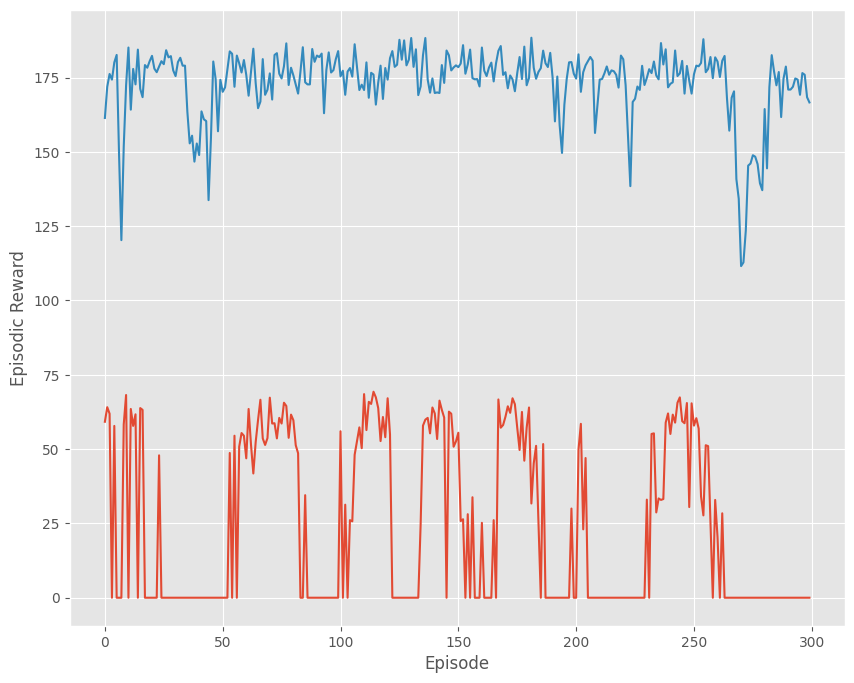

In [35]:
plt.plot(ep_reward_list0)
plt.plot(ep_reward_list1)
plt.xlabel("Episode")
plt.ylabel("Episodic Reward")
plt.show()

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,96,509,17.3,1525.7,103,12,0,369.10,12,369.50,35.20
1,0,1084,2296,3005.2,7094.6,597,51,11,1607.16,52,1825.54,279.86


,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
1,0,73570,2945,6097.29,8524.4,878,45,20,1486.52,50,1719.48,224.52


,rnd,period,step,current_bid,current_bid_idx,current_ask,buy,sell,price,sale,bprofit,sprofit
current_ask_idx,,,,,,,,,,,,
0,0,101,193,353.34,19,825.1,11,3,369.390,11,438.510,74.590
1,0,198,756,476.81,39,1874.8,1,0,35.400,1,25.800,2.000
2,0,224,484,554.54,44,1744.4,22,2,641.795,22,689.005,89.595
3,0,55,25,190.98,10,310.9,11,3,342.745,11,378.055,62.245
4,0,244,492,580.56,35,1598.3,11,3,358.230,12,504.070,63.030
5,0,358,855,866.27,60,2266.8,7,0,228.700,7,159.600,23.600


,rnd,period,step,current_bid,current_bid_idx,current_ask,buy,sell,price,sale,bprofit,sprofit
current_ask_idx,,,,,,,,,,,,
0,0,5293,138,457.98,18,619.7,7,6,302.735,10,224.165,34.735
1,0,8836,465,770.72,30,1105.8,0,0,0.000,0,0.000,0.000
2,0,10894,331,861.52,37,1231.3,19,9,593.960,20,568.940,91.960
3,0,2945,16,162.62,10,300.3,9,3,301.405,10,400.795,46.405
4,0,9122,319,684.22,31,1048.8,10,2,288.420,10,525.580,51.420
5,0,36480,1676,3160.23,124,4218.5,0,0,0.000,0,0.000,0.000


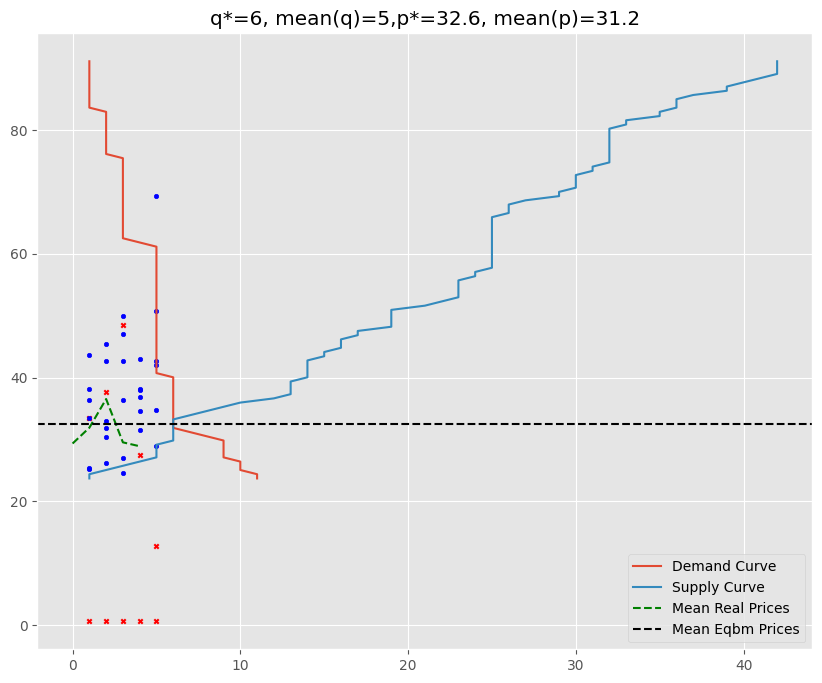

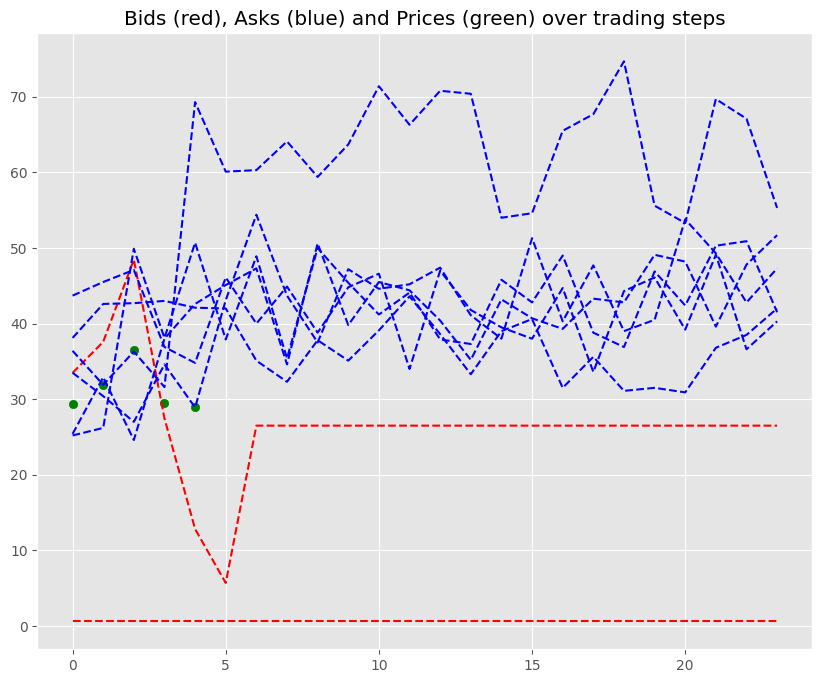

In [36]:
display(db.step_data.head(250).groupby('current_bid_idx').sum())
display(db.step_data.tail(250).groupby('current_bid_idx').sum())
display(db.step_data.head(250).groupby('current_ask_idx').sum())
display(db.step_data.tail(250).groupby('current_ask_idx').sum())
graph_period(env.db, 0, 280)

In [37]:
print(db.round_data.token_costs.item())
print(db.round_data.redemption_values.item())

[[ 26.8  36.3  52.8  57.5  70.1  73.2  74.3  87.3]
 [ 33.4  35.2  37.2  48.2  51.2  68.   83.2  98.5]
 [ 24.4  25.8  35.3  44.6  69.1  82.   87.9  91.8]
 [ 25.5  51.8  80.4  82.   86.   86.2  88.8 106.8]
 [ 23.7  34.5  43.   47.9  51.4  69.1  98.4 100.1]
 [ 29.3  36.4  40.   46.4  55.9  66.1  85.6 106. ]]
[[61.9 61.2 31.6 31.1 24.5 23.4 22.8 14.9]
 [91.1 83.4 75.8 40.2 30.1 26.5 18.5 14.7]]


In [38]:
db.step_data.tail(50)

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
7150,0,297,22,"[0.62, 26.5]","[38.4, 39.9, 40.9, 73.1, 41.0, 37.1]",26.50,1,37.1,5,False,False,NaN,0,0.000,0.000
7151,0,297,23,"[0.62, 26.5]","[40.3, 43.5, 52.1, 55.2, 45.5, 34.6]",26.50,1,34.6,5,False,False,NaN,0,0.000,0.000
7152,0,298,0,"[0.62, 18.29]","[38.8, 43.0, 32.1, 28.0, 28.7, 40.2]",18.29,1,28.0,3,True,False,28.000,1,63.100,2.500
7153,0,298,1,"[0.62, 33.29]","[35.1, 39.5, 30.9, 56.8, 25.0, 39.0]",33.29,1,25.0,4,True,True,29.145,1,54.255,5.445
7154,0,298,2,"[0.62, 36.06]","[37.0, 48.4, 35.5, 58.8, 38.0, 40.9]",36.06,1,35.5,2,True,True,35.780,1,40.020,11.380
7155,0,298,3,"[0.62, 20.43]","[31.3, 33.6, 29.2, 77.5, 48.1, 32.0]",20.43,1,29.2,2,True,False,29.200,1,11.000,3.400
7156,0,298,4,"[0.62, 30.1]","[37.6, 42.7, 46.2, 65.0, 45.1, 41.8]",30.10,1,37.6,0,False,True,30.100,1,0.000,3.300
7157,0,298,5,"[0.62, 26.5]","[45.2, 45.3, 44.2, 67.1, 42.0, 41.2]",26.50,1,41.2,5,False,False,NaN,0,0.000,0.000
7158,0,298,6,"[0.62, 26.5]","[46.1, 48.1, 42.4, 74.2, 44.0, 37.2]",26.50,1,37.2,5,False,False,NaN,0,0.000,0.000
7159,0,298,7,"[0.62, 26.5]","[40.0, 45.5, 47.8, 57.7, 38.9, 31.3]",26.50,1,31.3,5,False,False,NaN,0,0.000,0.000


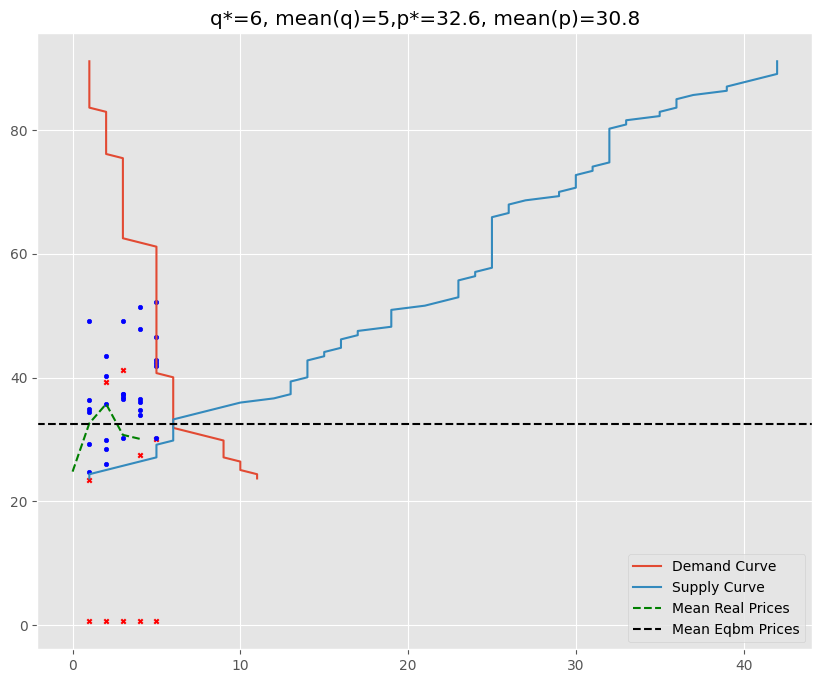

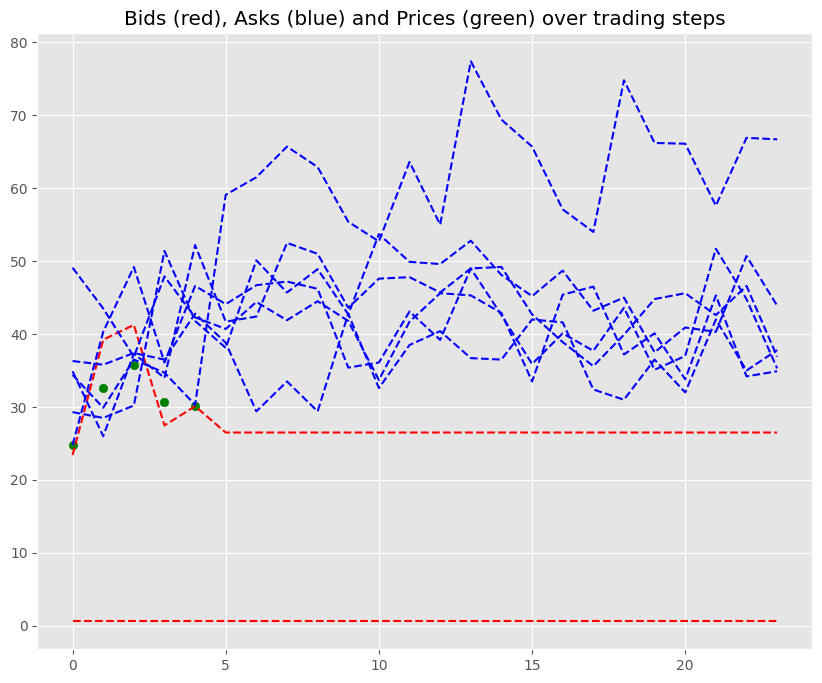

In [40]:
graph_period(env.db, 0, 299)